<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#без-BERT" data-toc-modified-id="без-BERT-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>без BERT</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#тестирование-модели" data-toc-modified-id="тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Задача построить модель со значением метрики качества *F1* не меньше 0.75. 


Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## без BERT

## Подготовка

Импортируем нужные библиотеки и зафиксируем случайность

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

state = np.random.RandomState(12345)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import re
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


перед нами задача бинарной классификации, посмотрим на распределение целевого признака

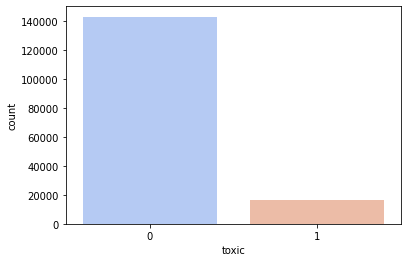

In [4]:
sns.countplot(x='toxic', data=data, palette='coolwarm');

Имеется дисбаланс признаков, при делении на обучающую и тестовую выборки будем стратифицировать по целевому признаку

Напишем функции для оперделения POS тэга, лемматизации и очистки текста:

In [5]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [6]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lemm_list])      
    return lemm_text

In [7]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = clear_text.lower().split()
    return ' '.join(clear_text)

Применим наши функции для создания нового столбца.

In [8]:
%%time
data['lemm_text'] = data['text'].apply(lambda text: lemmatize(clear_text(text)))

CPU times: user 16min, sys: 1min 34s, total: 17min 35s
Wall time: 17min 36s


In [9]:
data.head()

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Как говорилось ранее, поделим на выборки стратифицируя по целевому признаку

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    data['lemm_text'], data['toxic'], test_size=0.25, random_state=state, stratify=data['toxic'])

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((119469,), (39823,), (119469,), (39823,))

Создадим корпуса для выборок

In [12]:
#train_corpus = X_train.values.astype('U')
#test_corpus = X_test.values.astype('U')

для очистки корпусов используем стоп-слова, далее вычислим TF-IDF

In [13]:

count_tf_idf = TfidfVectorizer(stop_words=stop_words)
train_tf_idf = count_tf_idf.fit_transform(X_train)
test_tf_idf = count_tf_idf.transform(X_test)

In [14]:
display(train_tf_idf.shape, test_tf_idf.shape)

(119469, 127488)

(39823, 127488)

## Обучение

Обучим модели XGB и LGB с помощью подбора параметров по сетке.

In [15]:
%%time

xgb_clf = XGBClassifier(objective= 'binary:logistic', random_state=state, n_jobs=-1)

xgb_clf_params = {'max_depth' :[ 5, 10 ],
              'n_estimators': [100, 500]
}

xgb_clf_grid = GridSearchCV(xgb_clf, xgb_clf_params, scoring='f1')
xgb_clf_grid.fit(train_tf_idf, y_train)

xgb_clf_grid_best_params = xgb_clf_grid.best_params_

print('best parameters: ', xgb_clf_grid.best_params_)
print('best scores: ', xgb_clf_grid.best_score_)

[19:26:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:31:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:34:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [16]:
lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=state, class_weight='balanced')

In [17]:
%%time


lgbm_clf_params = {'n_estimators': [100, 500],
                   'max_depth' :[ 5, 10 ]}

lgbm_clf_grid = GridSearchCV(lgbm_clf, lgbm_clf_params, scoring='f1')
lgbm_clf_grid.fit(train_tf_idf, y_train)

lgbm_clf_grid_best_model = lgbm_clf_grid.best_params_

print('best parameters: ', lgbm_clf_grid.best_params_)
print('best scores: ', lgbm_clf_grid.best_score_)


best parameters:  {'max_depth': 10, 'n_estimators': 500}
best scores:  0.7605232279770694
CPU times: user 1h 37min 38s, sys: 30.5 s, total: 1h 38min 8s
Wall time: 1h 38min 48s


## тестирование модели

Тестировать будем модель XGB,т.к. она показала лучшие результаты на обучении.

In [25]:
def scoring(fitted_model):
    test_pred = fitted_model.predict(test_tf_idf)
    test_f1 = f1_score(y_test, test_pred)
    
    print('F1 на тестовой выборке: {:.3f}'.format(test_f1))

In [26]:
%%time
scoring(xgb_clf_grid.best_estimator_)

F1 на тестовой выборке: 0.767
CPU times: user 1.51 s, sys: 32.9 ms, total: 1.54 s
Wall time: 1.52 s


## Выводы

Мы подготовили данные путем оперделения POS тэга, лемматизации и очистки текста, расчета TF-IDF. 
Обучили 2 модели XGB и LGB, при обучении лучшие результаты показала модель XGB.
При тестировании модель XGB показала F1 равный 0.767, задача выполнена.